In [1]:
# imports

# python packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
import rpy2
from functools import reduce
import xarray as xr

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [2]:
# install & import r package sctransform

# # check if sctransform is installed
# if not ro.packages.isinstalled('sctransform'):
#     # select CRAN mirror
#     utils = importr('utils')
#     utils.chooseCRANmirror(ind=1)
#     # install sctransform
#     utils.install_packages(ro.vectors.StrVector(['sctransform']))
    
# check if glmGamPoi is installed
if not ro.packages.isinstalled('glmGamPoi'):
    print('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')

# import sctransform
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# should be version 0.3.5 or higher                           
print(sctransform.__version__)


0.3.5.9002


In [3]:
# helper functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix


# Read in collated mapping counts and metadata

In [4]:
# read in metadata

# filepaths
filepath_genome_metadata = '../../data/metadata/genome_metadata.csv'
filepath_ortholog_metadata = '../../data/metadata/ortholog_metadata.csv'
filepath_sample_metadata = '../../data/metadata/sample_metadata.csv'

# genome metadata
genome_df = pd.read_csv(filepath_genome_metadata)

#  ortholog metadata
ortholog_df = pd.read_csv(filepath_ortholog_metadata)

#  sample metadata
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['samplename'] = [name[:-2] for name in sample_df['SampleID']]
sample_df = sample_df.rename(columns={'SampleID': 'sample', 'Replicate': 'replicate'})

# create annotations_df to map annotations back to orthologs
annotations_df = ortholog_df[['OrthologID', 'Annotation']].drop_duplicates()
annotations_df = annotations_df.rename(columns={'OrthologID': 'ortholog', 'Annotation': 'annotation'})

sample_df


,sample,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,replicate,SmallFraction,LargeFraction,Unfractionated,samplename
0,G1.SURF.NS.S02C1.15m.A,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,A,G1.SURF.NS.S02C1.15m.0_2um.A,G1.SURF.NS.S02C1.15m.3um.A,False,G1.SURF.NS.S02C1.15m
1,G1.SURF.NS.S02C1.15m.B,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,B,G1.SURF.NS.S02C1.15m.0_2um.B,G1.SURF.NS.S02C1.15m.3um.B,False,G1.SURF.NS.S02C1.15m
2,G1.SURF.NS.S02C1.15m.C,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,C,G1.SURF.NS.S02C1.15m.0_2um.C,G1.SURF.NS.S02C1.15m.3um.C,False,G1.SURF.NS.S02C1.15m
3,G1.SURF.NS.S04C1.15m.A,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,A,G1.SURF.NS.S04C1.15m.0_2um.A,G1.SURF.NS.S04C1.15m.3um.A,False,G1.SURF.NS.S04C1.15m
4,G1.SURF.NS.S04C1.15m.B,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,B,G1.SURF.NS.S04C1.15m.0_2um.B,G1.SURF.NS.S04C1.15m.3um.B,False,G1.SURF.NS.S04C1.15m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G3.UW.NS.UW40_1.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,B,G3.UW.NS.UW40_1.7m.0_2um.B,G3.UW.NS.UW40_1.7m.3um.B,False,G3.UW.NS.UW40_1.7m
218,G3.UW.NS.UW40_1.7m.C,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,C,G3.UW.NS.UW40_1.7m.0_2um.C,G3.UW.NS.UW40_1.7m.3um.C,False,G3.UW.NS.UW40_1.7m
219,G3.UW.NS.UW40_2.7m.A,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,A,G3.UW.NS.UW40_2.7m.0_2um.A,G3.UW.NS.UW40_2.7m.3um.A,False,G3.UW.NS.UW40_2.7m
220,G3.UW.NS.UW40_2.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,B,G3.UW.NS.UW40_2.7m.0_2um.B,G3.UW.NS.UW40_2.7m.3um.B,False,G3.UW.NS.UW40_2.7m


In [5]:
# read in mapped transcript abundance data

filepath_data = '../../data/2-mapping/collated_salmon_data.csv.gz'
mappings_df = pd.read_csv(filepath_data)
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-311-D23_2717613068,360,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613068
1,AG-311-D23_2717613069,114,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613069
2,AG-311-D23_2717613070,1083,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613070
3,AG-311-D23_2717613071,1053,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613071
4,AG-311-D23_2717613072,1080,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613072
...,...,...,...,...,...,...,...
216275059,W9_2553539569,447,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539569
216275060,W9_2553539570,249,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539570
216275061,W9_2553539571,324,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539571
216275062,W9_2553539572,483,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539572


# Process mapped reads

- Drop reference genes without ortholog mapping (hypothesized to mostly be rRNA & other highly conserved RNA)
- Within each clade in each sample, aggregate reads mapping to the same ortholog


In [6]:
# directory to store output
output_dir = 'batch-test'


In [7]:
# collect reads mapping to known orthologs only and aggregate within orthologs

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads', 'GeneLength']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Genus'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Genus'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['OrthologID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['OrthologID'])

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['OrthologID'].isna()]

# aggregate all orthologs in same genus
pangenome_df = pangenome_df.groupby(['SampleID', 'Genus', 'Clade', 
                                  'OrthologID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Genus,Clade,OrthologID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000001.0,79.000,True
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000002.0,64.000,True
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000003.0,18.000,True
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000004.0,1583.802,True
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000005.0,814.674,True
...,...,...,...,...,...,...
21847903,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040282.0,0.000,False
21847904,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040288.0,0.000,False
21847905,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040290.0,0.000,False
21847906,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040293.0,0.000,False


In [52]:
pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum()).gt(3).value_counts()

Nonzero
True       2974
False        65
dtype: int64

# Separate out data by clade

In [65]:
# separate out data for most highly represented clades in dataset

# thresholds
detection_min = 3
coverage_threshold = 0.1
clades = {
    'pro': ['HLI', 'HLII', 'LLI'], 
    'syn': ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2']
}

# storage variables
ortho_list = []
sample_list = []
core_df_dict = {}

for selected_clade in clades['pro'] + clades['syn']:
    print(selected_clade)
    clade_pangenome_df = pangenome_df[pangenome_df.Clade == selected_clade]
    
    # make fresh directory
    dir_path = '{}/{}'.format(output_dir, selected_clade)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    # down-select data to detected orthologs
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
#     core_df = core_df[core_df.Nonzero.gt(0)]
    core_df = core_df[core_df.Nonzero.ge(detection_min)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]

    # down-select to only samples with coverage that is at least x% of the max coverage found in the dataset
    coverage = clade_pangenome_df.groupby('SampleID').Nonzero.sum()
    max_cov = coverage.max()
    total_orthos = len(core_df.index)
    print('Max coverage: {} / {} orthologs ({})'.format(max_cov, total_orthos, max_cov/total_orthos))
    samples = coverage[coverage.gt(coverage.max() * coverage_threshold)].index
    sample_list.append(samples)
    min_cov = coverage[samples].min()
    print('Min coverage: {} / {} orthologs ({})'.format(min_cov, total_orthos, min_cov/total_orthos))
    print('Total samples: {}\n'.format(len(samples)))
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df['SampleID'].isin(samples)]
    
    # down-select data to only orthologs that show up in a minimum number of the remaining samples
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.ge(detection_min)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]
    ortho_list.append(core_df.index)

    # pivot table
    clade_core_df = clade_pangenome_df.pivot(index='OrthologID', columns=['SampleID'], values='Reads')
    core_df_dict[selected_clade] = clade_core_df
    
    # save pre-normed data to csv
    clade_core_df.to_csv('{}/read_counts_{}.csv'.format(dir_path, selected_clade))
    

HLI
Max coverage: 2737 / 3255 orthologs (0.8408602150537634)
Min coverage: 445 / 3255 orthologs (0.13671274961597543)
Total samples: 132

HLII
Max coverage: 3222 / 3807 orthologs (0.8463356973995272)
Min coverage: 336 / 3807 orthologs (0.08825847123719464)
Total samples: 80

LLI
Max coverage: 2783 / 2899 orthologs (0.9599862021386685)
Min coverage: 304 / 2899 orthologs (0.1048637461193515)
Total samples: 85

5.1A-I
Max coverage: 2529 / 2980 orthologs (0.8486577181208054)
Min coverage: 259 / 2980 orthologs (0.08691275167785235)
Total samples: 171

5.1A-II
Max coverage: 2847 / 3049 orthologs (0.9337487700885536)
Min coverage: 319 / 3049 orthologs (0.10462446703837323)
Total samples: 45

5.1A-III
Max coverage: 1831 / 2155 orthologs (0.8496519721577727)
Min coverage: 274 / 2155 orthologs (0.1271461716937355)
Total samples: 44

5.1A-IV
Max coverage: 3026 / 3198 orthologs (0.9462163852407754)
Min coverage: 305 / 3198 orthologs (0.09537210756722952)
Total samples: 175

5.1B-VII
Max coverage: 

In [66]:
# look at intersections of samples and genes

# universal
print('Total cyanobacterial orthologs: {}'.format(len(reduce(np.union1d, ortho_list))))
print('Total cyanobacterial samples: {}'.format(len(reduce(np.union1d, sample_list))))
print('Shared cyanobacterial orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list))))
print('Shared cyanobacterial samples: {}\n'.format(len(reduce(np.intersect1d, sample_list))))

# pro
print('Total Pro orthologs: {}'.format(len(reduce(np.union1d, ortho_list[:3]))))
print('Total Pro samples: {}'.format(len(reduce(np.union1d, sample_list[:3]))))
print('Shared Pro orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[:3]))))
print('Shared Pro samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[:3]))))

# syn
print('Total Syn orthologs: {}'.format(len(reduce(np.union1d, ortho_list[3:]))))
print('Total Syn samples: {}'.format(len(reduce(np.union1d, sample_list[3:]))))
print('Shared Syn orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[3:]))))
print('Shared Syn samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[3:]))))


Total cyanobacterial orthologs: 10071
Total cyanobacterial samples: 221
Shared cyanobacterial orthologs: 1248
Shared cyanobacterial samples: 7

Total Pro orthologs: 5497
Total Pro samples: 134
Shared Pro orthologs: 1736
Shared Pro samples: 54

Total Syn orthologs: 6545
Total Syn samples: 221
Shared Syn orthologs: 1672
Shared Syn samples: 7



# Normalize data using sctransform

* Save diagnostic plots & csv files, as well as tensorized data in NetCDF4 format

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3250 by 132

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3250 genes, 132 cells



pro
HLI
  |======================================================================| 100%


R[write to console]: There are 3 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 970 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Resource ratio incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 3250 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 10.08724 secs



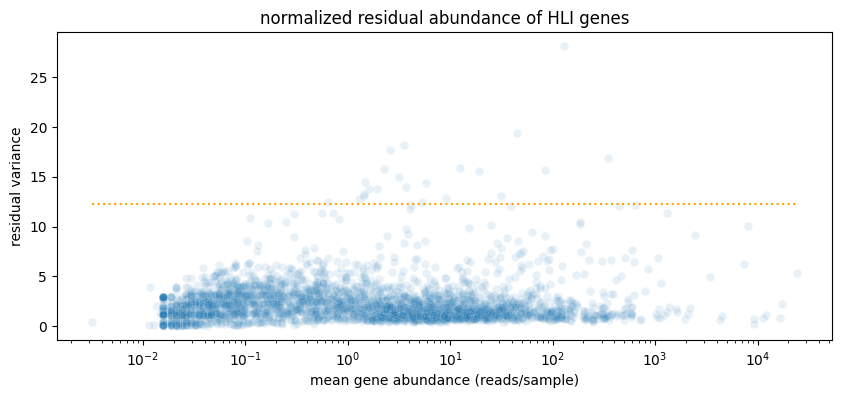

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3794 by 80

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3794 genes, 80 cells



HLII
  |======================================================================| 100%


R[write to console]: There are 4 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 1694 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 3794 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 7.708546 secs



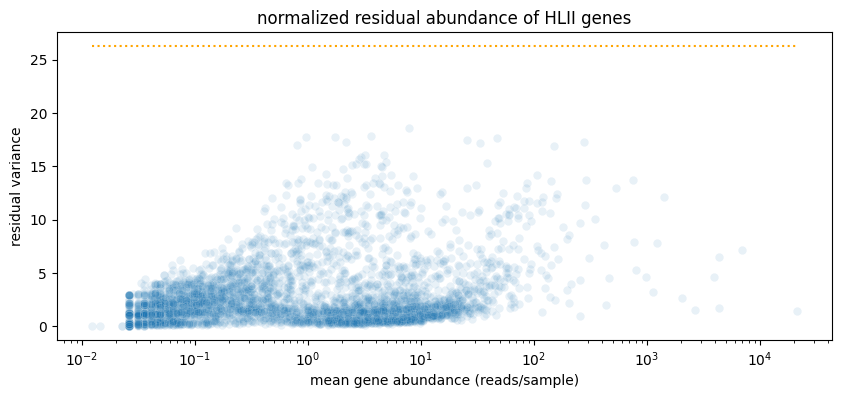

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 2897 by 85

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2897 genes, 85 cells



LLI
  |======================================================================| 100%


R[write to console]: Found 866 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Resource ratio incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 2897 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.469598 secs



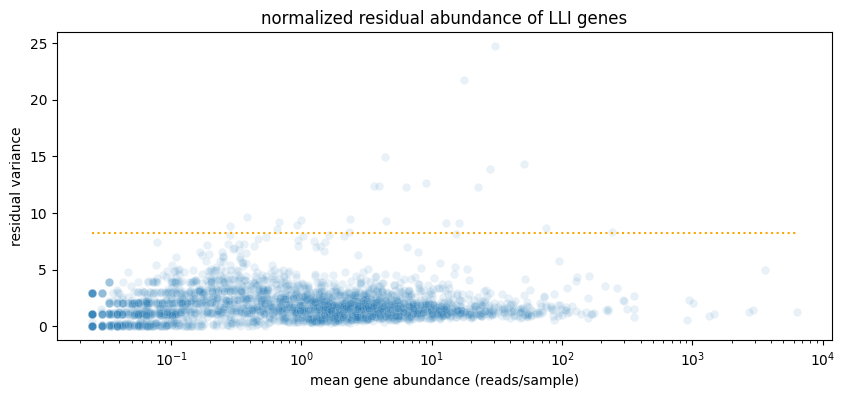

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 2978 by 171

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2978 genes, 171 cells



syn
5.1A-I
  |======================================================================| 100%


R[write to console]: Found 1417 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Resource ratio incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 diel study -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 2978 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 12.19102 secs



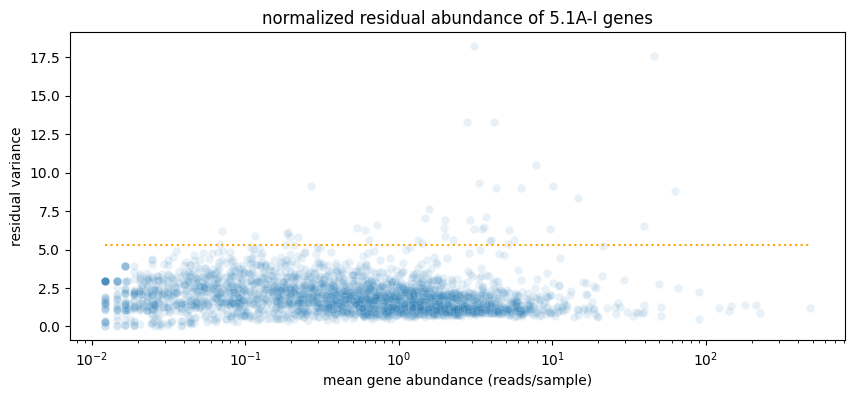

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3024 by 45

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3024 genes, 45 cells



5.1A-II
  |======================================================================| 100%


R[write to console]: Found 1053 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 3024 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 3.724674 secs



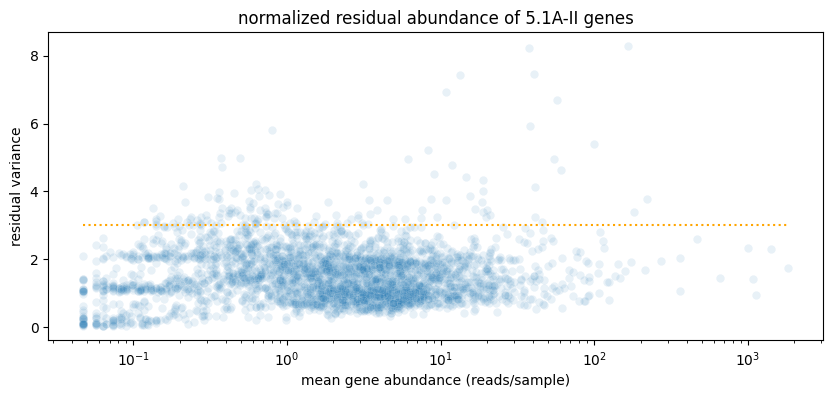

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 2125 by 44

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2125 genes, 44 cells



5.1A-III
  |======================================================================| 100%


R[write to console]: There are 10 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 745 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 2125 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.571782 secs



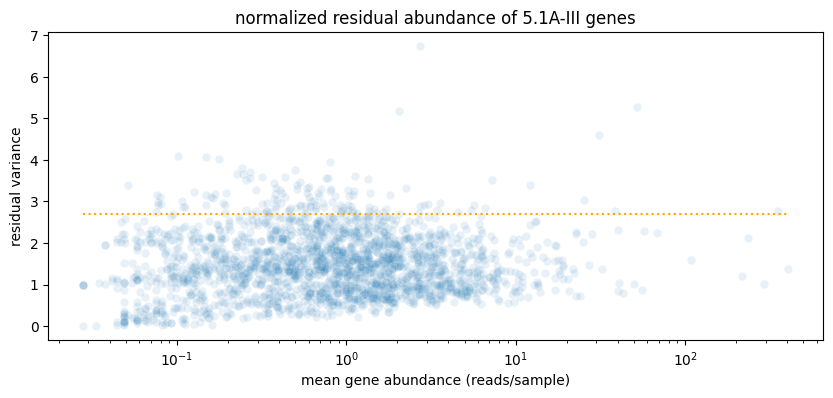

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3195 by 175

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3195 genes, 175 cells



5.1A-IV
  |======================================================================| 100%


R[write to console]: Found 679 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Resource ratio incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 diel study -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 3195 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 15.24465 secs



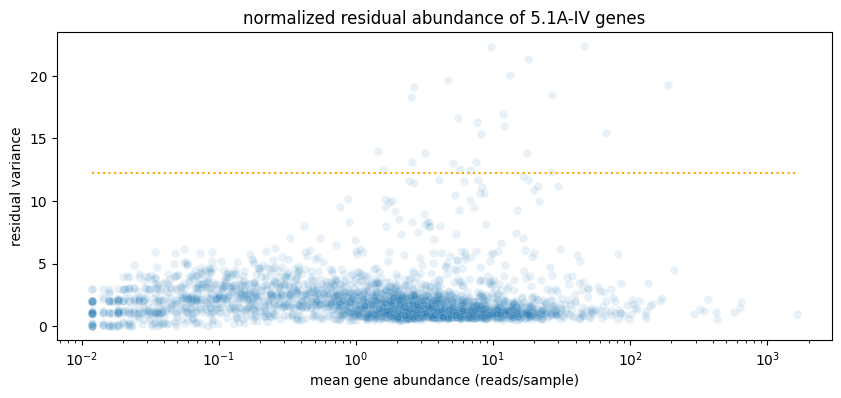

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3697 by 104

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3697 genes, 104 cells



5.1B-VII
  |======================================================================| 100%


R[write to console]: There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 986 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Resource ratio incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 3697 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 9.12353 secs



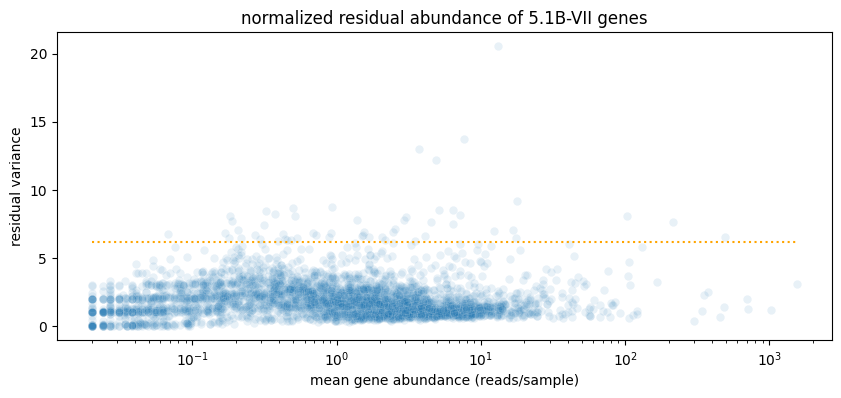

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3038 by 104

R[write to console]: Model formula is y ~ (log_umi) : Dataset + Dataset + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3038 genes, 104 cells



CDR2
  |======================================================================| 100%


R[write to console]: Found 785 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch Gradients 1 surface -- assuming a low mean.

R[write to console]: Some genes not detected in batch Bryn amendment incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 2 DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch Resource ratio incubation -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 depth profile -- assuming a low mean.

R[write to console]: Some genes not detected in batch Gradients 3 underway -- assuming a low mean.

R[write to console]: Second step: Get residuals using fitted parameters for 3038 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 7.048223 secs



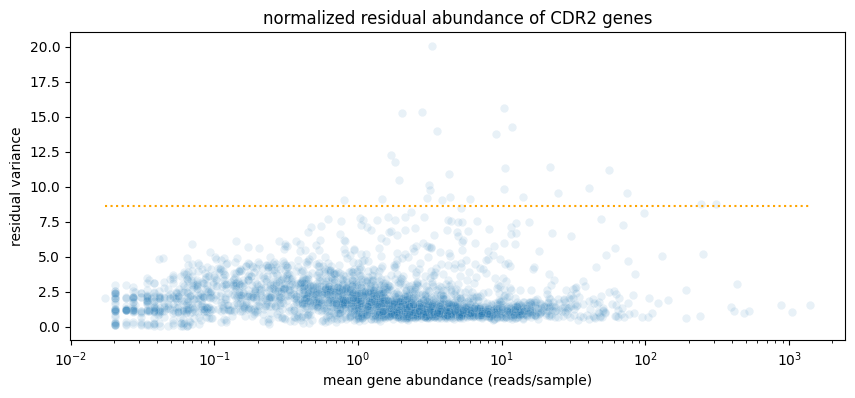

In [67]:
# run the model on each clade, saving outputs and plots

# store normalized data as slabs to arrange in xarray tensor
read_slabs = {}
residual_slabs = {}

# iterate through pro & syn
for genus in ['pro', 'syn']:
    print(genus)
    read_slabs[genus] = []
    residual_slabs[genus] = []
        
    # iterate through clades
    for clade in clades[genus]:
        print(clade)

        # make fresh directory
        dir_path = '{}/{}'.format(output_dir, clade)
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

        # convert clade_core_df to r matrix
        clade_core_df = core_df_dict[clade]
        r_clade_core_df = pandas_dataframe_to_r_matrix(clade_core_df)
        
        # pull out sample attributes
        sample_attr_df = sample_df.set_index('sample').loc[clade_core_df.columns, ['Dataset', 'Cruise']]
        r_sample_attr_df = pandas2ri.py2rpy(sample_attr_df)

        # fit vst normalization model
        result = sctransform.vst(
            r_clade_core_df, 
            cell_attr=r_sample_attr_df, 
            batch_var=ro.vectors.StrVector(["Dataset"]),
            method='glmGamPoi', 
            n_genes='null', 
            min_cells=detection_min,
            return_gene_attr=True, 
            return_cell_attr=True, 
#             vst_flavor='v2', 
            verbosity=10
        )

        # save residuals as csv
        residual_df = pd.DataFrame(
            np.asarray(result[0]), 
            index=clade_core_df.index, 
            columns=clade_core_df.columns
        )
        residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
        # save residuals as slab 
        slab = (
            residual_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='residual')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        residual_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))
        
        # save read counts as slab 
        slab = (
            clade_core_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='readcount')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        read_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))

        # save plot of model parameters
        plots = sctransform.plot_model_pars(result, show_theta=True)
        img = image_png(plots)
        with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
            png.write(img.data)

        # plot high variance genes
        residual_var = residual_df.var(axis=1)
        three_sigma = 1 + residual_var.var() * 3
        expression = clade_core_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
        plt.hlines(three_sigma, expression.min(), expression.max(), 
                   colors=['orange'], linestyles=[':'], label='3*sigma');
        plt.xlabel('mean gene abundance (reads/sample)')
        plt.xscale('log')
        plt.ylabel('residual variance')
        plt.title('normalized residual abundance of {} genes'.format(clade))
        plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
        plt.show()

        # save csv of residual variances with annotations
        res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
        res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('ortholog')['annotation'])
        res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
        res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))
        
#         https://github.com/satijalab/seurat/issues/3720


In [68]:
# make slabs into xarray tensors and save

# make DataArrays for metadata
replicate_da = xr.DataArray.from_series(sample_df.set_index('sample')['replicate'])
samplename_da = xr.DataArray.from_series(sample_df.set_index('sample')['samplename'])
annotation_da = xr.DataArray.from_series(annotations_df.set_index('ortholog')['annotation'])

for genus in ['pro', 'syn']:
    # make read count DataArray
    read_data = read_slabs[genus]
    read_all_slabs = pd.concat(read_data)
    read_da = xr.DataArray.from_series(read_all_slabs['readcount']).fillna(0)
    # make residual DataArray
    residual_data = residual_slabs[genus]
    residual_all_slabs = pd.concat(residual_data)
    residual_da = xr.DataArray.from_series(residual_all_slabs['residual']).fillna(0)
    # combine residuals with metadata into xarray Dataset
    ds = xr.Dataset(
        dict(
            readcount=read_da, 
            residual=residual_da, 
            replicate=replicate_da.loc[residual_da.sample],
            samplename=samplename_da.loc[residual_da.sample], 
            annotation=annotation_da.loc[residual_da.ortholog]
        )
    )
    # save as netCDF4 file in data directory
    ds.to_netcdf('{}/{}-tensor-dataset.nc'.format(output_dir, genus))

ds
    

<xarray.Dataset>
Dimensions:     (ortholog: 6545, clade: 6, sample: 221)
Coordinates:
  * ortholog    (ortholog) object 60000001 60000002 ... 60040245 60040289
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    residual    (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    replicate   (sample) object 'A' 'B' 'C' 'A' 'B' 'C' ... 'B' 'C' 'A' 'B' 'C'
    samplename  (sample) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS.UW40_2.7m'
    annotation  (ortholog) object 'membrane protease FtsH catalytic subunit' ...